#### CIFAR10 Attack Notebook

In [1]:
%%capture installation
import os
import sys
import argparse
import datetime

import numpy as np

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import yaml
from art.attacks.evasion import DeepFool, FastGradientMethod
from art.estimators.classification import PyTorchClassifier

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from typing import Callable, Tuple, Dict
from pathlib import Path
import pytorch_lightning as pl
from torch import nn

from dataloader import load_mnist
from models.autoencoder import (ANNAutoencoder, BaseAutoEncoder,
                                CelebAAutoencoder, CIFAR10Autoencoder)
from models.classifier import (CelebAClassifier, CIFAR10Classifier,
                                MNISTClassifier)

from attacks import ATTACK_MAPPINGS
from attacks.art_attack import execute_attack, get_models, get_xyz, hybridize
from attacks.plot_attack import plot_adversarial_images, plot_robust_accuracy
from dataloader import DATALOADER_MAPPINGS

2022-11-24 10:19:27.423757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 10:19:27.554928: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-24 10:19:27.560063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-24 10:19:27.560084: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [5]:
class Args:
    batch_size = 10
    attack_name = "deepfool"
    device  = "cuda"
    model_name = "cifar10_cnn_1"
    ae_name = "ann_128"
    plot = False
    plot_dir = "./plots"

args = Args()

In [6]:
attack_name = ATTACK_MAPPINGS.get(args.attack_name)
dataset_name = args.model_name.split("_")[0]
print(f"Working on the dataset: {dataset_name}!!!!!")

with open(f"./configs/{dataset_name}.yml", "r") as f:
    config = yaml.safe_load(f)

classifier_model, autoencoder_model, config = get_models(args)
print(f"Loaded classifier and autoencoder models in eval mode!!!!!")
_, _, test_dataloader = DATALOADER_MAPPINGS[config["dataset_name"]](batch_size=args.batch_size)
print(f"Loaded dataloader!!!!!") 

Working on the dataset: cifar10!!!!!
Loaded classifier and autoencoder models in eval mode!!!!!
Files already downloaded and verified
Files already downloaded and verified
Loaded dataloader!!!!!


In [7]:
x, y, z = get_xyz(args, autoencoder_model, test_dataloader)
    
config["latent_shape"] = args.ae_name.split('_')[-1]
classifier, hybrid_classifier, accuracy = hybridize(x, y, z, 
                                                    config, classifier_model, autoencoder_model)

# Perform attack
result: Dict = execute_attack(config, attack_name, x, y, z, classifier, hybrid_classifier, autoencoder_model)

Accuracy on benign test examples: 100.0%
Accuracy on benign test examples(from reconstructed): 60.0%


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Accuracy on adversarial test examples: 20.0%


DeepFool: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

Accuracy on adversarial test examples(Modified): 0.0%
Accuracy on adversarial test examples(Hybrid): 100.0%


In [8]:
orig_attk_images = result["DeepFool"]["x_test_adv_np"]
modf_attk_images = result["DeepFool"]["xx_test_adv_np"]

orig_attk_noise = result["DeepFool"]["x_test_noise"]
modf_attk_noise = result["DeepFool"]["xx_test_noise"]

import torchvision
def plot_images(images):
    plt.figure(figsize=(20, 2))
    images = torch.Tensor(images).reshape(-1, 3, 32, 32)
    # i = 1
    # for image in images:
    #     plt.subplot(5, 5, i, xticks=[], yticks=[])
    #     plt.imshow(np.transpose(image, (1, 2, 0)))
    #     i = i + 1

    #     if i == 26:
    #         break
    grid = torchvision.utils.make_grid(images, nrow=10, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


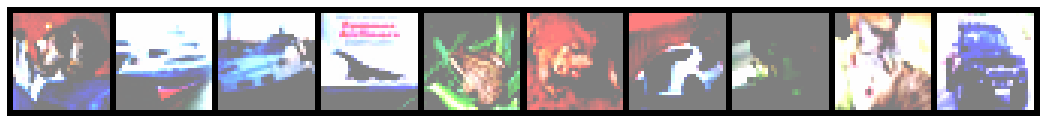

In [9]:
plot_images(orig_attk_images)

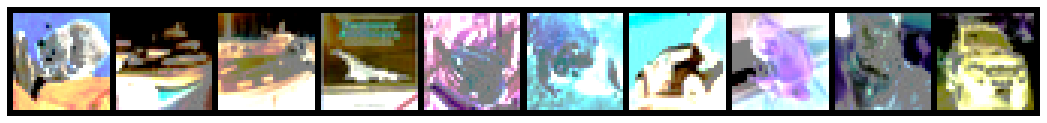

In [10]:
plot_images(orig_attk_noise)

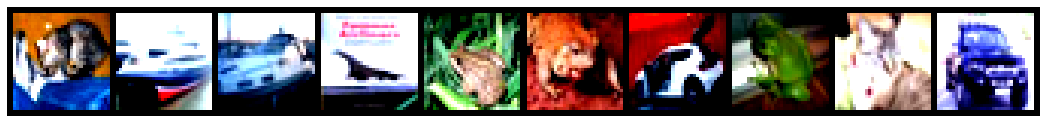

In [11]:
plot_images(x[1])

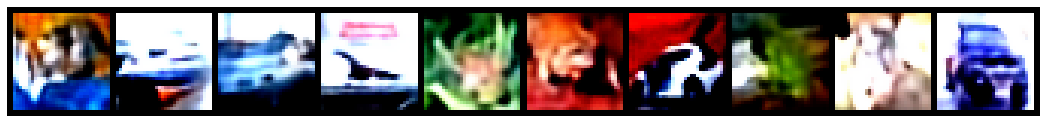

In [12]:
plot_images(modf_attk_images)

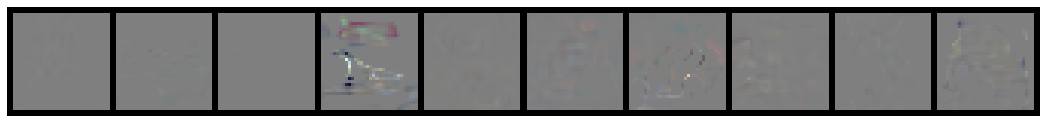

In [13]:
plot_images(modf_attk_noise)

In [19]:
def calculate_accuracy(model, images, labels):
    correct = 0
    total = 0

    # images, labels = images.to(device), labels.to(device)
    # calculate outputs by running images through the network
    outputs = model(images)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total

    return accuracy

# images, labels = next(iter(test_dataloader))
acc = calculate_accuracy(classifier_model, x[0], y[0])
print(f"Accuracy on test samples: {acc}%")

hybrid_classifier_model = nn.Sequential(
            autoencoder_model.decoder,
            classifier_model.model
        )
acc = calculate_accuracy(hybrid_classifier_model, z[0], y[0])
print(f"Accuracy on reconstructed test samples: {acc}%")

Accuracy on test samples: 100%
Accuracy on reconstructed test samples: 60%


##### LPIPS

In [16]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores

# LPIPS between original and original attacks
import torch
img0 = torch.Tensor(orig_attk_images) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = x[0].detach().cpu()
d = loss_fn_alex(img0, img1)
print(d.flatten())

print(d.flatten().mean())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/sweta/scratch/miniconda3/envs/py38/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
tensor([0.1229, 0.0826, 0.0769, 0.0557, 0.0996, 0.1642, 0.1601, 0.3526, 0.0550,
        0.0569], grad_fn=<ReshapeAliasBackward0>)
tensor(0.1226, grad_fn=<MeanBackward0>)


In [17]:
# LPIPS between original and modified attacks
import torch
img0 = torch.Tensor(modf_attk_images) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = x[0].detach().cpu()
d = loss_fn_alex(img0, img1)
print(d.flatten())

print(d.flatten().mean())

tensor([0.0451, 0.0251, 0.0491, 0.0342, 0.0395, 0.0322, 0.0211, 0.0308, 0.0361,
        0.0281], grad_fn=<ReshapeAliasBackward0>)
tensor(0.0341, grad_fn=<MeanBackward0>)
